
---
# **Project Overview**
---

This project focuses on building an automated technical support system that analyzes incoming customer emails to route them to the appropriate team, assign priority, and estimate resolution time.
The main problem addressed is the time and effort wasted in manually reviewing and responding to customer support emails. By automating this process, the system helps reduce response time and improves overall customer support efficiency.

In this project, I apply **`Core Natural Language Processing (NLP) techniques`** based on **traditional fastText models**, representing the era before deep learning approaches such as **RNNs and Transformers**. The goal is to demonstrate how effective classic NLP pipelines can still be in real-world applications.


## **NLP Pipeline**

The following preprocessing and modeling steps were implemented:

* Fix encoding and Unicode issues

* Remove HTML tags

* Normalize whitespace

* Convert text to lowercase

* Expand contractions

* Apply spell checking

* Remove stopwords

* Apply lemmatization

* Train a fastText model


## **Who Is This Notebook For?**

This notebook is suitable for **NLP beginners** who want to learn how to work with text data and understand the key text preprocessing steps.

---

## **Author**

 - **Name:** **Mohamed Mamdouh**
 - Student at the Faculty of **Artificial Intelligence**

 - [**LinkedIn**](https://www.linkedin.com/in/ai-mohamed-mamdouh-74043b331/)
 - [**GitHub**](https://github.com/ai-mohamed-mamdouh)
 - [**Kaggle**](https://www.kaggle.com/mohamed00mamdouh)

---

# **Import & Read**

In [1]:
DATA_PATH = '/content/drive/MyDrive/DataColab/NLP_project/Technical Support/dataSet/technical_support.csv'

In [2]:
# !pip install fasttext
# !pip install pyspellchecker
# !pip install contractions

In [3]:
import numpy as np
import pandas as pd
import spacy

import warnings
warnings.filterwarnings("ignore")

In [4]:
encodings = ["utf-8", "utf-8-sig", "cp1252", "latin-1"]
for enc in encodings:
    try:
        data = pd.read_csv(DATA_PATH, encoding=enc)
        print(f"Read successfully with {enc}")
        break
    except UnicodeDecodeError:
        print(f"Failed with {enc}")

Read successfully with utf-8


In [5]:
data.head()

,Ticket_ID,Customer_Name,Customer_Email,Ticket_Subject,Ticket_Description,Issue_Category,Priority_Level,Ticket_Channel,Submission_Date,Resolution_Time_Hours,Assigned_Agent,Satisfaction_Score
0,TKT-100000,George Simon,lisastrickland@example.com,Hours of operation - Individual,"Hi Support, Where is your headquarters located...",General Inquiry,High,Web Form,2025-07-02,43,David Kim,5
1,TKT-100001,Scott Thompson,wevans@example.org,Data not syncing - Card,"Hi Support, The application crashes every time...",Technical,High,Chat,2025-06-28,41,Elena Rodriguez,5
2,TKT-100002,Jennifer Smith,oleonard@example.net,2FA issues - Question,"Hi Support, How do I upgrade to the Enterprise...",Account,High,Web Form,2025-02-05,7,Anya Sharma,5
3,TKT-100003,Rachel Bullock,katherine67@example.net,Login failed - Let,"Hi Support, The dashboard is not loading any d...",Technical,Low,Web Form,2025-03-20,41,Anya Sharma,5
4,TKT-100004,Thomas Parks DDS,raykelsey@example.com,Refund status - Attention,"Hi Support, I have been trying to update my pa...",Billing,Medium,Email,2025-04-27,40,David Kim,5


In [6]:
data.columns = data.columns.str.lower()
data['email_domain'] = data['customer_email'].str[-3 : ].str.replace('.' , '')

# **EDA**

In [7]:
print(data.shape)
print(data.isnull().sum().sum())
print(data.duplicated().sum())

(20000, 13)
0
0


In [8]:
data.head()

,ticket_id,customer_name,customer_email,ticket_subject,ticket_description,issue_category,priority_level,ticket_channel,submission_date,resolution_time_hours,assigned_agent,satisfaction_score,email_domain
0,TKT-100000,George Simon,lisastrickland@example.com,Hours of operation - Individual,"Hi Support, Where is your headquarters located...",General Inquiry,High,Web Form,2025-07-02,43,David Kim,5,com
1,TKT-100001,Scott Thompson,wevans@example.org,Data not syncing - Card,"Hi Support, The application crashes every time...",Technical,High,Chat,2025-06-28,41,Elena Rodriguez,5,org
2,TKT-100002,Jennifer Smith,oleonard@example.net,2FA issues - Question,"Hi Support, How do I upgrade to the Enterprise...",Account,High,Web Form,2025-02-05,7,Anya Sharma,5,net
3,TKT-100003,Rachel Bullock,katherine67@example.net,Login failed - Let,"Hi Support, The dashboard is not loading any d...",Technical,Low,Web Form,2025-03-20,41,Anya Sharma,5,net
4,TKT-100004,Thomas Parks DDS,raykelsey@example.com,Refund status - Attention,"Hi Support, I have been trying to update my pa...",Billing,Medium,Email,2025-04-27,40,David Kim,5,com


In [9]:
print('---------Values Count---------')
print('         ============         ')
for col in ['email_domain' , 'priority_level' , 'issue_category' , 'satisfaction_score'] :
  print('==='*10)
  print(data[col].value_counts(ascending=False))


---------Values Count---------
email_domain
org    6714
com    6652
net    4659
io     1975
Name: count, dtype: int64
priority_level
Low         7716
Medium      7570
High        3416
Critical    1298
Name: count, dtype: int64
issue_category
Technical          5918
Billing            5036
Account            4081
General Inquiry    3925
Fraud              1040
Name: count, dtype: int64
satisfaction_score
4    6783
5    6763
3    2584
1    1965
2    1905
Name: count, dtype: int64


In [10]:
data.groupby('issue_category')['priority_level'].value_counts(ascending=False)

issue_category   priority_level
Account          Low               2054
                 Medium            1622
                 High               405
Billing          Low               2524
                 Medium            1962
                 High               550
Fraud            Critical           716
                 High               324
General Inquiry  Low               1968
                 Medium            1568
                 High               389
Technical        Medium            2418
                 High              1748
                 Low               1170
                 Critical           582
Name: count, dtype: int64

In [11]:
data.groupby('email_domain')['priority_level'].value_counts(ascending=False)

email_domain  priority_level
com           Low               2565
              Medium            2553
              High              1107
              Critical           427
io            Low                761
              Medium             731
              High               352
              Critical           131
net           Low               1816
              Medium            1732
              High               788
              Critical           323
org           Low               2574
              Medium            2554
              High              1169
              Critical           417
Name: count, dtype: int64

In [12]:
data.groupby('satisfaction_score')['priority_level'].value_counts(ascending=False)

satisfaction_score  priority_level
1                   Low                807
                    Medium             675
                    High               313
                    Critical           170
2                   Low                754
                    Medium             686
                    High               295
                    Critical           170
3                   Low               1006
                    Medium             975
                    High               405
                    Critical           198
4                   Medium            2647
                    Low               2590
                    High              1172
                    Critical           374
5                   Medium            2587
                    Low               2559
                    High              1231
                    Critical           386
Name: count, dtype: int64

# **Peprocessing Steps**


 - → FIX ENCODING / UNICODE
 - → REMOVE HTML
 - → NORMALIZE WHITESPACE
 - → LOWERCASE
 - → CONTRACTIONS
 - → SPELLCHECK
 - → TOKENIZE
 - → NEGATION
 - → STOPWORDS
 - → LEMMATIZATION

# **Clean Text**

In [13]:
import re
import string
from bs4 import BeautifulSoup

In [14]:
df = data[[  'email_domain',
      'ticket_subject',
       'ticket_description',
        'issue_category',
        'priority_level' ,
        'resolution_time_hours',
        'satisfaction_score']]

df['text'] = df['ticket_subject'].astype(str) + ' ' + df['ticket_description'].astype(str)

df = df[[  'email_domain',
         'text',
        'issue_category',
        'priority_level' ,
        'resolution_time_hours',
        'satisfaction_score']]

In [15]:
def clean_text (text) :
  text = BeautifulSoup(text ,'html.parser').get_text()

  url_pattern = r'https?://\S+|www\.\S+'
  email_pattern = r'\b[\w\.-]+@[\w\.-]+\.\w+\b'
  text = re.sub(url_pattern , '' , text)
  text = re.sub(email_pattern , '' , text)

  text = re.sub(r'\s+' , ' ' , text).strip()

  text = text.translate( str.maketrans('' ,'' , string.punctuation) )

  return text.lower()

In [16]:
import unicodedata
def fix_unicode(text):
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    return text

In [17]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(fix_unicode)

df['issue_category'] = df['issue_category'].apply(clean_text)
df['priority_level'] = df['priority_level'].apply(clean_text)

df['issue_category'] = df['issue_category'].str.replace(' ' , '_')

# **Contractions**

In [18]:
import spacy
import contractions as con

In [19]:
def contraction_fast(text):
    return con.fix(text)

In [20]:
df['text'] = df['text'].astype(str).map(contraction_fast)

# **Spell Checker**

In [21]:
from functools import lru_cache
from spellchecker import SpellChecker

spell = SpellChecker()

In [22]:
@lru_cache(maxsize=50000)

def fix_word(word):
    return spell.correction(word)

def correct_spell(text):
    return ' '.join(fix_word(w) for w in text.split()).lower()

In [23]:
df['text'] = df['text'].apply(correct_spell)

# **Lemmatization**

In [24]:
nlp = spacy.load(
    "en_core_web_sm",
    disable=["ner", "parser", "textcat", "attribute_ruler"]
)

In [25]:
def lemmatize_column(texts, batch_size=1000, n_process=1):
    docs = nlp.pipe(texts.astype(str), batch_size=batch_size, n_process=n_process)
    return [' '.join(t.lemma_ for t in doc).lower() for doc in docs]

In [26]:
df['text'] = lemmatize_column(df['text'], batch_size=1000, n_process=2)

# **Remove StopWord**

In [27]:
import re

STOPWORDS = set([
    "the","is","in","at","of","on","and","a","to","for","with","that","this"
])

def remove_stopwords(text: str) -> str:
    words = text.lower().split()

    return " ".join(w for w in words if w not in STOPWORDS)

In [28]:
df['text'] = df['text'].apply(remove_stopwords)

In [29]:
df.head()

,email_domain,text,issue_category,priority_level,resolution_time_hours,satisfaction_score
0,com,hours operation individual hi support where yo...,general_inquiry,high,43,5
1,org,data not syncing card hi support application c...,technical,high,41,5
2,net,fa issues question hi support how do i upgrade...,account,high,7,5
3,net,login failed let hi support dashboard not load...,technical,low,41,5
4,com,refund status attention hi support i have been...,billing,medium,40,5


In [30]:
df.to_csv('technical_support_processed.csv', index = False)

# **FastText(issue_category)**

In [31]:
import fasttext

In [32]:
df_ft = df.copy()

In [33]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(df_ft , test_size=0.2 , shuffle = True , stratify=df_ft['issue_category'])

## **Save files in correct FastText format**

In [34]:
with open("train.train", "w", encoding="utf-8") as f:
    for _, row in train.iterrows():
        label = row["issue_category"]
        text = str(row["text"]).replace("\n", " ")
        f.write(f"__label__{label} {text}\n")

In [35]:
with open("test.test", "w", encoding="utf-8") as f:
    for _, row in test.iterrows():
        label = row["issue_category"]
        text = str(row["text"]).replace("\n", " ")
        f.write(f"__label__{label} {text}\n")

## **Train fastText Base Model**

In [37]:
model = fasttext.train_supervised(input='/content/train.train')

In [38]:
model.test('/content/test.test')

(4000, 1.0, 1.0)

In [39]:
df['text'][0]

'hours operation individual hi support where your headquarters located lay soon message show know main'

In [40]:
label , prop = model.predict([df['text'][0]])
print(label[0])
print(prop[0])

['__label__general_inquiry']
[0.9987331]


## **Evaluate fasttext model**

In [41]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

def evaluate_fasttext_model(
    model,
    df: pd.DataFrame,
    text_col: str = "text",
    label_col: str = "Issue_Category",
    k: int = 1,
    show_confusion_df: bool = True,
    plot_confusion: bool = False,
    top_errors: int = 20
):
    """
    Evaluate a fastText supervised model on a DataFrame with columns:
      - text_col: raw text
      - label_col: true label (multi-class)

    Returns:
      results dict containing metrics + confusion matrix + errors df
    """

    data = df[[text_col, label_col]].copy()
    data = data.dropna(subset=[text_col, label_col])

    data[text_col] = (
        data[text_col].astype(str)
        .str.replace("\n", " ", regex=False)
        .str.strip()
    )
    data[label_col] = (
        data[label_col].astype(str)
        .str.strip()
        .str.replace(" ", "_", regex=False)
    )

    data = data[data[text_col].str.len() > 0].reset_index(drop=True)

    if len(data) == 0:
        raise ValueError("No valid rows after cleaning. Check for NaNs/empty texts.")


    texts = data[text_col].tolist()


    labels, probs = model.predict(texts, k=k)


    y_true = data[label_col].tolist()

    if k == 1:
        y_pred = [lab_list[0].replace("__label__", "") for lab_list in labels]
        y_conf = [float(prob_list[0]) for prob_list in probs]
    else:
        y_pred = [lab_list[0].replace("__label__", "") for lab_list in labels]
        y_conf = [float(prob_list[0]) for prob_list in probs]

    data["y_true"] = y_true
    data["y_pred"] = y_pred
    data["conf"] = y_conf



    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)


    labels_order = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    cm_df = pd.DataFrame(
        cm,
        index=[f"true_{l}" for l in labels_order],
        columns=[f"pred_{l}" for l in labels_order]
    )


    pr, rc, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_order, zero_division=0
    )
    per_class = {
        lab: {"precision": float(p), "recall": float(r), "f1": float(ff), "support": int(s)}
        for lab, p, r, ff, s in zip(labels_order, pr, rc, f1, sup)
    }




    errors = data[data["y_true"] != data["y_pred"]].copy()
    errors = errors.sort_values("conf", ascending=False).head(top_errors)




    if plot_confusion:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation="nearest")
        plt.xticks(range(len(labels_order)), labels_order, rotation=45, ha="right")
        plt.yticks(range(len(labels_order)), labels_order)
        plt.colorbar()
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()



    print(f"Samples evaluated: {len(data)}")
    print(f"Accuracy: {acc:.4f}\n")
    print("Classification Report:\n")
    print(report)

    if show_confusion_df:
        print("\nConfusion Matrix (counts):")
        display(cm_df)


    if "Fraud" in per_class:
        f = per_class["Fraud"]
        print("\nFraud class focus:")
        print(f"  Precision: {f['precision']:.4f} | Recall: {f['recall']:.4f} | F1: {f['f1']:.4f} | Support: {f['support']}")

    return {
        "accuracy": float(acc),
        "classification_report_text": report,
        "labels_order": labels_order,
        "confusion_matrix": cm,
        "confusion_matrix_df": cm_df,
        "per_class_metrics": per_class,
        "errors_top": errors,
        "predictions_df": data
    }

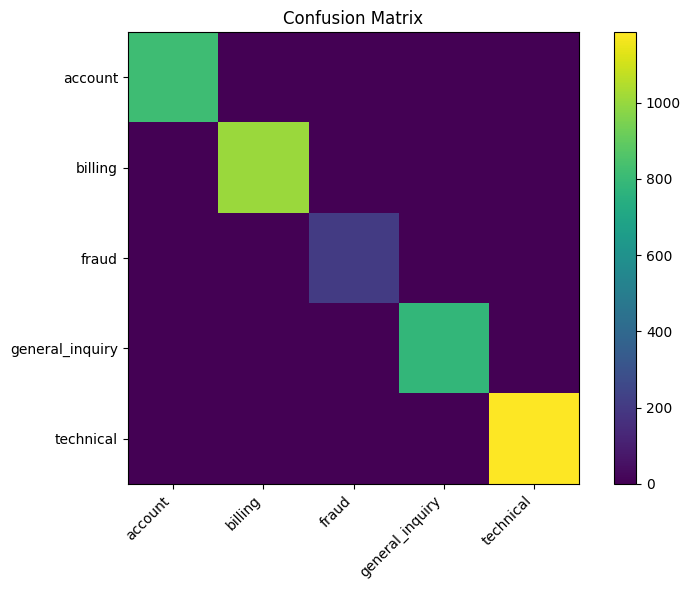

Samples evaluated: 4000
Accuracy: 1.0000

Classification Report:

                 precision    recall  f1-score   support

        account     1.0000    1.0000    1.0000       816
        billing     1.0000    1.0000    1.0000      1007
          fraud     1.0000    1.0000    1.0000       208
general_inquiry     1.0000    1.0000    1.0000       785
      technical     1.0000    1.0000    1.0000      1184

       accuracy                         1.0000      4000
      macro avg     1.0000    1.0000    1.0000      4000
   weighted avg     1.0000    1.0000    1.0000      4000


Confusion Matrix (counts):


,pred_account,pred_billing,pred_fraud,pred_general_inquiry,pred_technical
true_account,816,0,0,0,0
true_billing,0,1007,0,0,0
true_fraud,0,0,208,0,0
true_general_inquiry,0,0,0,785,0
true_technical,0,0,0,0,1184


,y_true,y_pred,conf,text


In [42]:
results = evaluate_fasttext_model(
    model=model,
    df=test,
    text_col="text",
    label_col="issue_category",
    k=1,
    plot_confusion=True,
    top_errors=20
)


results["errors_top"][["y_true","y_pred","conf","text"]]

In [43]:
# model.save_model("technical_support_fasttext(issue_category).bin")

# **Project Summary**

This project demonstrates how `traditional NLP techniques` can be used to build an automated technical support system that processes customer emails, reduces manual effort, and speeds up response time. By applying essential text preprocessing steps and training a fastText model, the project highlights the effectiveness of classic NLP approaches in real-world text classification tasks.